# Feature Engineering para Detecção de Fraudes

Este notebook implementa a criação de features para o modelo de detecção de fraudes em transações de cartão de crédito.

In [1]:
# 1. Setup e Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import json
import pathlib
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de plotagem
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Obter o caminho da raiz do projeto
current_path = pathlib.Path().absolute()
if current_path.name == 'notebooks':
    project_root = current_path.parent
else:
    project_root = current_path

# Definir caminhos para as pastas de dados
RAW_DATA_DIR = os.path.join(project_root, 'data', 'raw')
PROCESSED_DATA_DIR = os.path.join(project_root, 'data', 'processed')

# Garantir que as pastas existam
os.makedirs(RAW_DATA_DIR, exist_ok=True)
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

In [2]:
# 2. Carregar Dados e Insights da EDA
print("Carregando dados de transações...")
transactions_file = os.path.join(RAW_DATA_DIR, 'transactions_2024.parquet')
df = pd.read_parquet(transactions_file)
print(f"Carregados {len(df):,} transações")

# Carregar insights da EDA
insights_file = os.path.join(PROCESSED_DATA_DIR, 'eda_insights.json')
with open(insights_file, 'r') as f:
    insights = json.load(f)
print("Insights da EDA carregados com sucesso!")

Carregando dados de transações...
Carregados 10,000 transações
Insights da EDA carregados com sucesso!


In [3]:
# Função corrigida para contar transações nas últimas 24 horas
def count_txns_last_24h(group):
    """
    Conta quantas transações foram realizadas nas últimas 24 horas para cada transação
    """
    # Garantir que timestamp seja datetime
    if not pd.api.types.is_datetime64_any_dtype(group['timestamp']):
        group['timestamp'] = pd.to_datetime(group['timestamp'])
    
    # Ordenar transações por timestamp
    group = group.sort_values('timestamp')
    timestamps = group['timestamp'].tolist()
    counts = []
    
    for i, ts in enumerate(timestamps):
        # Correção: Calcular a diferença de tempo para cada transação anterior
        count = 0
        for prev_ts in timestamps[:i]:
            # Verificar se a transação anterior ocorreu nas últimas 24 horas
            if isinstance(ts, datetime) and isinstance(prev_ts, datetime):
                if (ts - prev_ts) <= timedelta(hours=24):
                    count += 1
        counts.append(count)
    
    return counts


=== Criando Features Temporais ===


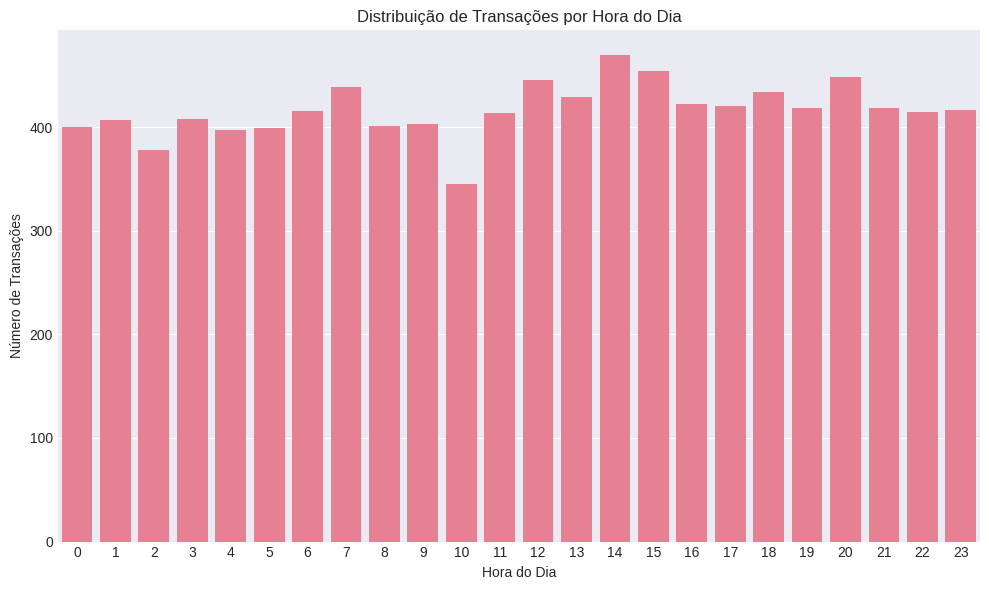

In [4]:
# 3. Feature Engineering
print("\n=== Criando Features Temporais ===")

# Converter timestamp para datetime se necessário
if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
    df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extrair features temporais
df['hour_of_day'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Visualizar distribuição de transações por hora do dia
plt.figure(figsize=(10, 6))
sns.countplot(x='hour_of_day', data=df)
plt.title('Distribuição de Transações por Hora do Dia')
plt.xlabel('Hora do Dia')
plt.ylabel('Número de Transações')
plt.tight_layout()
plt.show()

In [5]:
# Features de Velocidade
print("\n=== Criando Features de Velocidade ===")
print("Calculando transações nas últimas 24 horas por cliente...")

# Aplicar a função por cliente
df['txn_count_24h'] = df.groupby('customer_id').apply(
    lambda x: pd.Series(count_txns_last_24h(x), index=x.index)
).reset_index(level=0, drop=True)

# Feature de alta velocidade
df['high_velocity'] = (df['txn_count_24h'] > insights['velocity_threshold']).astype(int)


=== Criando Features de Velocidade ===
Calculando transações nas últimas 24 horas por cliente...


In [8]:
# 4. Features de Valor
print("\n=== Criando Features de Valor ===")

# Calcular estatísticas de valor por cliente
customer_stats = df.groupby('customer_id')['amount'].agg(['mean', 'std', 'max']).reset_index()
customer_stats.columns = ['customer_id', 'avg_amount', 'std_amount', 'max_amount']

# Mesclar de volta ao dataframe principal
df = pd.merge(df, customer_stats, on='customer_id', how='left')

# Criar feature de valor anômalo
df['amount_zscore'] = df.groupby('customer_id')['amount'].transform(
    lambda x: (x - x.mean()) / x.std() if len(x) > 1 and x.std() > 0 else 0
)

# Usar o valor 3.0 como threshold padrão para z-score se não estiver definido nos insights
amount_zscore_threshold = insights.get('amount_zscore_threshold', 3.0)
print(f"Usando threshold de z-score para anomalias: {amount_zscore_threshold}")
df['is_amount_anomaly'] = (abs(df['amount_zscore']) > amount_zscore_threshold).astype(int)


=== Criando Features de Valor ===
Usando threshold de z-score para anomalias: 3.0


In [10]:
# Verificar as colunas disponíveis
print("\nColunas disponíveis no DataFrame:")
print(df.columns.tolist())

# Verificar se temos dados de localização em outro formato
# Por exemplo, talvez os dados de localização estejam em colunas com nomes diferentes
location_cols = [col for col in df.columns if 'lat' in col.lower() or 'lon' in col.lower() or 'coord' in col.lower()]
print("\nPossíveis colunas de localização:")
print(location_cols)


Colunas disponíveis no DataFrame:
['transaction_id', 'customer_id', 'merchant_id', 'timestamp', 'amount', 'is_fraud', 'hour_of_day', 'day_of_week', 'is_weekend', 'txn_count_24h', 'high_velocity', 'avg_amount_x', 'std_amount_x', 'max_amount_x', 'amount_zscore', 'avg_amount_y', 'std_amount_y', 'max_amount_y', 'is_amount_anomaly']

Possíveis colunas de localização:
[]


In [14]:
# 5. Features de Localização
print("\n=== Criando Features de Localização ===")

# Verificar se as colunas de localização existem
print("Verificando colunas de localização...")
location_columns_exist = all(col in df.columns for col in ['latitude', 'longitude'])

if not location_columns_exist:
    print("Colunas de localização (latitude, longitude) não encontradas no DataFrame.")
    print("Pulando o cálculo de features de localização.")
    
    # Adicionar colunas vazias para manter a consistência
    df['distance_from_prev'] = 0.0
    df['time_since_prev'] = pd.Timedelta(seconds=0)
    df['speed'] = 0.0
    df['impossible_travel'] = 0
else:
    # Calcular distância entre transações consecutivas (simplificado)
    def calculate_distance_features(group):
        group = group.sort_values('timestamp')
        
        # Inicializar colunas
        group['distance_from_prev'] = 0.0
        group['time_since_prev'] = pd.Timedelta(seconds=0)
        group['speed'] = 0.0
        
        # Calcular para cada transação após a primeira
        for i in range(1, len(group)):
            # Distância em km (simplificada usando coordenadas cartesianas)
            lat1, lon1 = group.iloc[i-1]['latitude'], group.iloc[i-1]['longitude']
            lat2, lon2 = group.iloc[i]['latitude'], group.iloc[i]['longitude']
            
            # Distância euclidiana aproximada (para simplificar)
            dist = np.sqrt((lat2 - lat1)**2 + (lon2 - lon1)**2) * 111  # 1 grau ≈ 111 km
            group.iloc[i, group.columns.get_loc('distance_from_prev')] = dist
            
            # Tempo desde a transação anterior
            time_diff = group.iloc[i]['timestamp'] - group.iloc[i-1]['timestamp']
            group.iloc[i, group.columns.get_loc('time_since_prev')] = time_diff
            
            # Velocidade em km/h
            hours = time_diff.total_seconds() / 3600
            if hours > 0:
                speed = dist / hours
                group.iloc[i, group.columns.get_loc('speed')] = speed
        
        return group

    # Aplicar função por cliente
    print("Calculando features de distância e velocidade...")
    df = df.groupby('customer_id').apply(calculate_distance_features).reset_index(drop=True)
    
    # Identificar transações com velocidade impossível
    max_possible_speed = insights.get('max_possible_speed', 1000)  # Valor padrão se não existir
    df['impossible_travel'] = (df['speed'] > max_possible_speed).astype(int)


=== Criando Features de Localização ===
Verificando colunas de localização...
Colunas de localização (latitude, longitude) não encontradas no DataFrame.
Pulando o cálculo de features de localização.


In [16]:
# 6. Salvar Dataset Processado
print("\n=== Salvando Dataset com Features ===")

# Verificar e corrigir colunas duplicadas
print("Verificando colunas duplicadas...")
columns_list = df.columns.tolist()
duplicate_columns = set([col for col in columns_list if columns_list.count(col) > 1])

if duplicate_columns:
    print(f"Encontradas colunas duplicadas: {duplicate_columns}")
    
    # Renomear colunas duplicadas
    new_columns = []
    seen_columns = set()
    
    for i, col in enumerate(df.columns):
        if col in seen_columns:
            # Adicionar sufixo para colunas duplicadas
            count = 1
            new_col = f"{col}_{count}"
            while new_col in seen_columns:
                count += 1
                new_col = f"{col}_{count}"
            print(f"Renomeando coluna duplicada: {col} -> {new_col}")
            new_columns.append(new_col)
        else:
            new_columns.append(col)
            seen_columns.add(col)
    
    # Aplicar novos nomes de colunas
    df.columns = new_columns
    print("Colunas duplicadas resolvidas.")

# Salvar o DataFrame
output_file = os.path.join(PROCESSED_DATA_DIR, 'transactions_features.parquet')
df.to_parquet(output_file)
print(f"Dataset salvo em {output_file}")
print(f"Total de features criadas: {df.shape[1] - 7}")  # Subtrair as colunas originais


=== Salvando Dataset com Features ===
Verificando colunas duplicadas...
Encontradas colunas duplicadas: {'std_amount', 'max_amount', 'avg_amount'}
Renomeando coluna duplicada: avg_amount -> avg_amount_1
Renomeando coluna duplicada: std_amount -> std_amount_1
Renomeando coluna duplicada: max_amount -> max_amount_1
Colunas duplicadas resolvidas.
Dataset salvo em /home/ricardo/Projects/personal-projects/github/credit-risk-ml/data/processed/transactions_features.parquet
Total de features criadas: 16


In [18]:
# Mostrar as primeiras linhas do dataset com as novas features
print("\nPrimeiras linhas do dataset com as novas features:")
print(df.head())

# Obter os nomes reais das colunas para o resumo
temporal_features = [col for col in df.columns if col in ['hour_of_day', 'day_of_week', 'is_weekend']]
velocity_features = [col for col in df.columns if col in ['txn_count_24h', 'high_velocity']]
value_features = [col for col in df.columns if 'amount' in col.lower() or col == 'is_amount_anomaly']
location_features = [col for col in df.columns if col in ['distance_from_prev', 'time_since_prev', 'speed', 'impossible_travel']]

# Resumo das features criadas
print("\nResumo das features criadas com nomes reais:")
print(f"1. Features Temporais: {', '.join(temporal_features)}")
print(f"2. Features de Velocidade: {', '.join(velocity_features)}")
print(f"3. Features de Valor: {', '.join(value_features)}")
print(f"4. Features de Localização: {', '.join(location_features)}")

# Mostrar todas as colunas para referência
print("\nTodas as colunas no DataFrame final:")
print(df.columns.tolist())


Primeiras linhas do dataset com as novas features:
  transaction_id customer_id merchant_id           timestamp      amount  \
0     TX00000000       C0643       M0029 2024-04-12 23:00:00  125.625688   
1     TX00000001       C0360       M0019 2024-04-02 18:00:00    4.768767   
2     TX00000002       C0540       M0073 2024-01-15 22:00:00  318.540350   
3     TX00000003       C0811       M0138 2024-04-16 11:00:00   95.200950   
4     TX00000004       C0609       M0101 2024-03-12 16:00:00  237.634943   

   is_fraud  hour_of_day  day_of_week  is_weekend  txn_count_24h  ...  \
0         0           23            4           0              0  ...   
1         0           18            1           0              0  ...   
2         0           22            0           0              0  ...   
3         0           11            1           0              0  ...   
4         0           16            1           0              0  ...   

    max_amount  amount_zscore  avg_amount_1  std_amo